In [298]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [413]:
# user defined functions

# remove the top and bottom 5% of data
def removeExtreme(df, column):
    max_ = df[column].quantile(0.95)
    min_ = df[column].quantile(0.05)
    return df[(df[column] > min_) & (df[column] < max_)]

# create a distribution of bootstrapped sample means 
def bootstrap(df, column, iterations):
    bootstap_mean = []
    for _ in range(iterations):
        data = np.random.choice(df[column], replace = True, size = iterations)
        bootstap_mean.append(np.mean(data))
    return bootstap_mean 

In [456]:
# define parameters 

ticker = 'SPY'
startDate = '2021-01-01'
endDate = '2022-12-31'
dataInterval = '1h'

fastSMA = 9
normalSMA = 50
slowSMA = 200

# moving average period
rollingPeriod = 21

# entry ratio
entryPercentile = 0.10

# exit ratio
exitPercentile = 0.90

In [481]:
# get data
df = yf.download(ticker, startDate, endDate, interval = dataInterval)
df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [482]:
# add indicators to dataframe
df['fastSMA'] = df['Close'].rolling(fastSMA).mean()
df['normalSMA'] = df['Close'].rolling(normalSMA).mean()
df['slowSMA'] = df['Close'].rolling(slowSMA).mean()

# drop nulls
df.dropna(inplace=True)
df.reset_index(inplace=True, drop = True)

# If close is higher than slowSMA, then trend in up
df['Trend'] = 'Down'
df.loc[df['Close'] >= df['slowSMA'], 'Trend'] = 'Up'

In [483]:
# calculate the area between slow and fast sma
df['spead_fastSMA_normalSMA'] =  (df['fastSMA'] - df['normalSMA']) / abs(df['Close'] - df['normalSMA'])
df['spead_slowSMA_normalSMA'] =  (df['slowSMA'] - df['normalSMA']) / abs(df['Close'] - df['normalSMA'])

# remove extreme obs
df = removeExtreme(df, 'spead_fastSMA_normalSMA')
df = removeExtreme(df, 'spead_slowSMA_normalSMA')

In [484]:
# define trend 
# slow crossed over fast
df['slowFast_CrossedOver'] = 'Up'
df.loc[df['slowSMA'] >= df['fastSMA'], 'slowFast_CrossedOver'] = 'Down'

# slow crossed over normal
df['slowNormal_CrossedOver'] = 'Up'
df.loc[df['slowSMA'] >= df['normalSMA'], 'slowNormal_CrossedOver'] = 'Down'

# fast crossed over normal
df['fastNormal_CrossedOver'] = 'Up'
df.loc[df['fastSMA'] >= df['normalSMA'], 'fastNormal_CrossedOver'] = 'Down'

# bootstap dataset and calculate sample means
spead_fastSMA_normalSMA_bootstrapped_mean = bootstrap(df, 'spead_fastSMA_normalSMA', 1000)
spead_slowSMA_normalSMA_bootstrapped_mean = bootstrap(df, 'spead_slowSMA_normalSMA', 1000)

# reset index
df.reset_index(inplace=True, drop = True)


In [485]:
# get the date of when the cross over occured
# create empty placeholder initalized with the first period

try:
    period = [df['Date'][0]]
except KeyError:
    period = [df['index'][0]]

keyDate = []
for i in range(len(df) - 1):
    
    # get current and prior status
    currentStatus = df['fastNormal_CrossedOver'][i+1]
    priorStatus = df['fastNormal_CrossedOver'][i]
    
    # if the status has not changed
    if currentStatus == priorStatus:
        # then set the current period equal to the prior one
        period.append(period[-1])
        keyDate.append(0)
    # if there has been a crossover
    else:
        try:
            period.append(df['Date'][i+1])
        except KeyError:
            period.append(df['index'][i+1])
        keyDate.append(1)
keyDate.append(0)
        
# cross over key date?  
df['Date_fastNormal_CrossedOver_key_Date'] = keyDate
# date when cross over occured    
df['Date_fastNormal_CrossedOver'] = period

In [486]:
# merge df to get the Closing price of crossover date
try:
    data = df[['Date','Close']].copy()
except KeyError:
    data = df[['index','Close']].copy()

data.columns = ['Date_fastNormal_CrossedOver','Close_fastNormal_CrossedOver']
df = df.merge(data, how = 'left', left_on = 'Date_fastNormal_CrossedOver', right_on = 'Date_fastNormal_CrossedOver')

# ROI from when the crossover occured
df['ROI_fastNormal_CrossedOver'] = df['Close'] / df['Close_fastNormal_CrossedOver'] - 1

# ROI if strategy was in place
roi = df.loc[df['Date_fastNormal_CrossedOver_key_Date']==1]

In [490]:
try:
    keyColumns = ['Date_fastNormal_CrossedOver','Date','ROI_fastNormal_CrossedOver',
              'slowFast_CrossedOver','fastNormal_CrossedOver','slowNormal_CrossedOver','Trend']
    roi = roi[keyColumns].copy()

    roi['Days_Spread'] = roi['Date'] - roi['Date_fastNormal_CrossedOver']
    roi['Days_Spread'] = [x.days for x in roi['Days_Spread']]
except KeyError:
    keyColumns = ['Date_fastNormal_CrossedOver','index','ROI_fastNormal_CrossedOver',
              'slowFast_CrossedOver','fastNormal_CrossedOver','slowNormal_CrossedOver','Trend']
    roi = roi[keyColumns].copy()
    roi['Days_Spread'] = roi['index'] - roi['Date_fastNormal_CrossedOver']
    roi['Days_Spread'] = [x.days for x in roi['Days_Spread']]
    



In [491]:
roi_bootstrapped_mean = bootstrap(roi, 'ROI_fastNormal_CrossedOver', 1000)
Days_Spread_bootstrapped_mean = bootstrap(roi, 'Days_Spread', 1000)


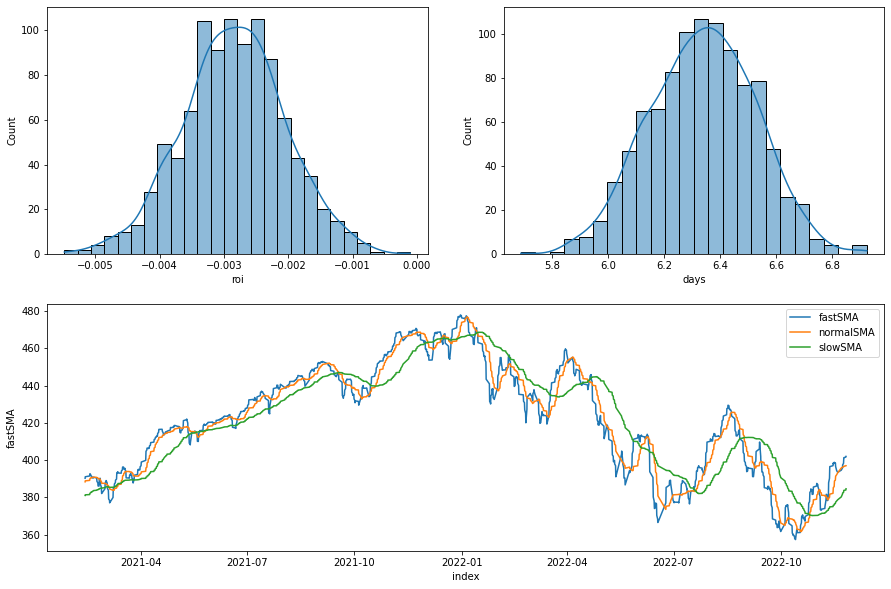

In [501]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.histplot(roi_bootstrapped_mean, kde=True).set(xlabel='roi')

plt.subplot(2,2,2)
sns.histplot(Days_Spread_bootstrapped_mean, kde=True).set(xlabel='days')

plt.subplot(2,1,2)
sns.lineplot(x=df['index'],y=df['fastSMA'], label='fastSMA')
sns.lineplot(x=df['index'],y=df['normalSMA'], label='normalSMA')
sns.lineplot(x=df['index'],y=df['slowSMA'], label='slowSMA')


plt.show()


In [494]:
roi.sort_values('index').tail()

#   Trend Level 1 - Slowest
#         'slowNormal_CrossedOver': 'Slow SMA is ABOVE Normal SMA'
#             -- 'Macro Trend'
#             -- 'Yes': 'Down Trending Long Term Trend'
#             -- 'No': 'Up Trending  Long Term Trend'

#   Trend Level 2 - Normal
#         'Trend': 'Price is ABOVE slow SMA'
#             -- 'Micro Trend'
#             -- 'Up': 'Up Trending Near-Term Trend'
#             -- 'Down': 'Down Trending  Near-Term Trend'

#   Trend Level 3 - Fastest
#         'slowFast_CrossedOver': 'Slow SMA is ABOVE Fast SMA'
#             -- 'Mirco-Mirco Trend'
#             --'Yes': 'Down Trend Micro-Micro Trend'
#             --'No': 'Up Trend Micro-Micro Trend'

#    Entry Signal
#         'fastNormal_CrossedOver': 'Fast SMA is ABOVE Normal SMA'
#             -- 'Entry Signal'
#             -- 'Yes' : 'BUY'
#             -- 'No': 'SELL'

#    Expected ROI
#         'ROI_fastNormal_CrossedOver': 'ROI based on each signal' 
#

roi.rename(columns={'slowNormal_CrossedOver':'Trend-Slow',
                   'Trend':'Trend-Normal',
                   'slowFast_CrossedOver':'Trend-Fast',
                   'fastNormal_CrossedOver':'Signal-Entry-Exit',
                   'ROI_fastNormal_CrossedOver':'Signal-Return',
                   'Days_Spread': 'Signal-Days'}, inplace=True)

In [495]:
roi.groupby(['Trend-Slow','Trend-Normal','Trend-Fast','Signal-Entry-Exit',
             ]).describe()['Signal-Return']

count      mean  \
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                    
Down       Down         Down       Down                14.0 -0.019659   
                                   Up                  15.0 -0.027756   
           Up           Down       Up                   6.0  0.006719   
Up         Down         Up         Down                 5.0 -0.010101   
                                   Up                   1.0  0.000487   
           Up           Down       Up                   1.0 -0.000048   
                        Up         Down                24.0  0.013510   
                                   Up                  20.0  0.006489   

                                                           std       min  \
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                       
Down       Down         Down       Down               0.012928 -0.039651   
                                   Up                 0.039079 -0.105176   
           Up           Down       Up                 0.013696 -0.017309   
Up         Down         Up         Down               0.008368 -0.018379   
                                   Up                      NaN  0.000487   
           Up           Down       Up                      NaN -0.000048   
                        Up         Down               0.019615 -0.021050   
                                   Up                 0.006911 -0.005408   

                                                           25%       50%  \
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                       
Down       Down         Down       Down              -0.025810 -0.019051   
                                   Up                -0.054424 -0.015728   
           Up           Down       Up                 0.003983  0.007358   
Up         Down         Up         Down              -0.013988 -0.011796   
                                   Up                 0.000487  0.000487   
           Up           Down       Up                -0.000048 -0.000048   
                        Up         Down               0.000000  0.007817   
                                   Up                 0.000853  0.006790   

                                                           75%       max  
Trend-Slow Trend-Normal Trend-Fast Signal-Entry-Exit                      
Down       Down         Down       Down              -0.012253  0.008420  
                                   Up                -0.002462  0.022652  
           Up           Down       Up                 0.015935  0.021252  
Up         Down         Up         Down              -0.010153  0.003813  
                                   Up                 0.000487  0.000487  
           Up           Down       Up                -0.000048 -0.000048  
                        Up         Down               0.026189  0.049211  
                                   Up                 0.010284  0.022321

In [ ]:
# Best Long Signal
'Trend-Slow' = 'Up',
'Trend-Normal' = 'Up',
'Trend-Fast' = 'Up',
'Signal-Entry-Exit' = 'Down'

# second Best Long Signal
'Trend-Slow' = 'Up',
'Trend-Normal' = 'Up',
'Trend-Fast' = 'Up',
'Signal-Entry-Exit' = 'Up'



# Best Short Signal
'Trend-Slow' = 'Down',
'Trend-Normal' = 'Down',
'Trend-Fast' = 'Down',
'Signal-Entry-Exit' = 'Up'

# second Best Short Signal
'Trend-Slow' = 'Down',
'Trend-Normal' = 'Down',
'Trend-Fast' = 'Down'
'Signal-Entry-Exit' = 'Down'

In [503]:
df.rename(columns={'slowNormal_CrossedOver':'Trend-Slow',
                   'Trend':'Trend-Normal',
                   'slowFast_CrossedOver':'Trend-Fast',
                   'fastNormal_CrossedOver':'Signal-Entry-Exit',
                   'ROI_fastNormal_CrossedOver':'Signal-Return',
                   'Days_Spread': 'Signal-Days',
                  'Date_fastNormal_CrossedOver_key_Date': 'TradeEvent'}, inplace=True)


In [504]:
df[['index','Trend-Slow','Trend-Normal','Trend-Fast','Signal-Entry-Exit','TradeEvent']].tail()

,index,Trend-Slow,Trend-Normal,Trend-Fast,Signal-Entry-Exit,TradeEvent
2543,2022-11-23 15:30:00-05:00,Up,Up,Up,Down,0
2544,2022-11-25 09:30:00-05:00,Up,Up,Up,Down,0
2545,2022-11-25 10:30:00-05:00,Up,Up,Up,Down,0
2546,2022-11-25 11:30:00-05:00,Up,Up,Up,Down,0
2547,2022-11-25 13:00:00-05:00,Up,Up,Up,Down,0
